In [1]:
import os
import re
import random
from argparse import Namespace

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import torchaudio
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sentence_transformers import SentenceTransformer

import sacrebleu
import sentencepiece

import textgrids

from fairseq import utils
from fairseq.data import Dictionary, data_utils as fairseq_data_utils
from fairseq.models.mST.w2v2_transformer import W2V2Transformer
from fairseq.data.audio.multilingual_triplet_v2_dataset import (
    MultilingualTripletDataConfig,
    MultilingualTripletDataset,
    MultilingualTripletDatasetCreator
)
from fairseq.data.audio.speech_to_text_dataset import get_features_or_waveform, _collate_frames
from examples.speech_to_text.data_utils import load_df_from_tsv, save_df_to_tsv
from fairseq.checkpoint_utils import load_checkpoint_to_cpu, save_state, torch_persistent_save

In [2]:
matplotlib.rcParams['font.sans-serif'] = ['SimHei'] 
matplotlib.rcParams['font.family'] ='sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False

In [3]:
device = th.device('cuda:4')

# Load Checkpoints

In [4]:
args = Namespace()
task = Namespace()
def load_dict(vocab_filename):
    _dict_path = vocab_filename
    if not os.path.isfile(_dict_path):
        raise FileNotFoundError(f"Dict not found: {_dict_path}")
    _dict = Dictionary.load(_dict_path)
    for code in codes:
        _dict.add_symbol(MultilingualTripletDataset.LANG_TAG_TEMPLATE.format(code))
    _dict.add_symbol('<mask>')
    return _dict
lang_list_filename = '/mnt/data/siqiouyang/runs/mST/pretrained/mbart50.ft.n1/ML50_langs.txt'
vocab_filename = '/mnt/data/siqiouyang/runs/mST/pretrained/mbart50.ft.n1/dict.txt'
codes = MultilingualTripletDataset.get_lang_codes(lang_list_filename)
dict = load_dict(vocab_filename)
task.src_dict = task.tgt_dict = dict
args.w2v2_model_path = '/mnt/data/siqiouyang/runs/mST/pretrained/xlsr2_300m.pt'
args.mbart50_dir = '/mnt/data/siqiouyang/runs/mST/pretrained/mbart50.ft.n1'
good_model = W2V2Transformer.build_model(args, task)
bad_model = W2V2Transformer.build_model(args, task)

In [5]:
# good_tag = 'xlsr_mbart_de_zh_align_cos_classify_gamma_0.05_emb'
good_tag = 'xlsr_mbart_de_zh_baseline'
bad_tag = 'xlsr_mbart_de_zh'

In [6]:
# bad_ckpt_path = '/mnt/data/siqiouyang/runs/mST/xlsr_mbart_de_zh/checkpoint_best.pt'
# bad_ckpt_path = '/mnt/data/siqiouyang/runs/mST/xlsr_mbart_de_zh_align_cos/checkpoint_best.pt'
# bad_ckpt_path = '/mnt/data/siqiouyang/runs/mST//checkpoint_best.pt'
# good_ckpt_path = '/mnt/data/siqiouyang/runs/mST/xlsr_mbart_de_zh_baseline/checkpoint_best.pt'
bad_ckpt_path = '/mnt/data/siqiouyang/runs/mST/{}/checkpoint_best.pt'.format(bad_tag)
good_ckpt_path = '/mnt/data/siqiouyang/runs/mST/{}/checkpoint_best.pt'.format(good_tag)
bad_ckpt = load_checkpoint_to_cpu(bad_ckpt_path)
good_ckpt = load_checkpoint_to_cpu(good_ckpt_path)
bad_model.load_state_dict(bad_ckpt["model"], strict=False)
good_model.load_state_dict(good_ckpt["model"], strict=False)
bad_model = bad_model.to(device)
good_model = good_model.to(device)
bad_model.eval()
good_model.eval()

W2V2Transformer(
  (encoder): W2V2TransformerEncoder(
    (w2v2_model): Wav2Vec2Model(
      (feature_extractor): ConvFeatureExtractionModel(
        (conv_layers): ModuleList(
          (0): Sequential(
            (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
            (1): Dropout(p=0.0, inplace=False)
            (2): Sequential(
              (0): TransposeLast()
              (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (2): TransposeLast()
            )
            (3): GELU()
          )
          (1): Sequential(
            (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
            (1): Dropout(p=0.0, inplace=False)
            (2): Sequential(
              (0): TransposeLast()
              (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (2): TransposeLast()
            )
            (3): GELU()
          )
          (2): Sequential(
            (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
  

In [ ]:
good_enc_bad_dec = W2V2Transformer.build_model(args, task)
good_enc_bad_dec.encoder.load_state_dict(good_model.encoder.state_dict())
good_enc_bad_dec.decoder.load_state_dict(bad_model.decoder.state_dict())
good_enc_bad_dec = good_enc_bad_dec.to(device)
good_enc_bad_dec.eval()

In [ ]:
bad_enc_good_dec = W2V2Transformer.build_model(args, task)
bad_enc_good_dec.encoder.load_state_dict(bad_model.encoder.state_dict())
bad_enc_good_dec.decoder.load_state_dict(good_model.decoder.state_dict())
bad_enc_good_dec = bad_enc_good_dec.to(device)
bad_enc_good_dec.eval()

<All keys matched successfully>

In [ ]:
good_enc_bad_dec_ckpt = load_checkpoint_to_cpu(good_ckpt_path)
for key in good_enc_bad_dec_ckpt['model']:
    if key.startswith('decoder'):
        good_enc_bad_dec_ckpt['model'][key] = bad_ckpt['model'][key]
torch_persistent_save(good_enc_bad_dec_ckpt, 'good_enc_bad_dec.pt')

In [ ]:
bad_enc_good_dec_ckpt = load_checkpoint_to_cpu(good_ckpt_path)
for key in bad_enc_good_dec_ckpt['model']:
    if key.startswith('encoder'):
        bad_enc_good_dec_ckpt['model'][key] = bad_ckpt['model'][key]
torch_persistent_save(bad_enc_good_dec_ckpt, 'bad_enc_good_dec.pt')

# Generate by Both Models

```bash
CUDA_VISIBLE_DEVICES=3 fairseq-generate ${COVOST2_ROOT} --gen-subset zh-CN_en_test \
  --task multilingual_speech_to_text --path /mnt/data/siqiouyang/runs/mST/xlsr_mbart_de_zh_baseline/checkpoint_best.pt \
  --prefix-size 1 --max-tokens 3200000 --max-source-positions 400000 --beam 4 --scoring sacrebleu \
  --config-yaml config_mST.yaml --lenpen 1.0 --results-path /home/siqiouyang/work/projects/mST/mST/analysis/language_transfer/generations/xlsr_mbart_de_zh_baseline
```

In [7]:
def extract(path):
    refs = []
    gens = []
    with open(path, 'r') as r:
        for line in r.readlines():
            line = line.strip()
            parts = line.split('\t')
            if line.startswith('T-'):
                refs.append(parts[1])
            elif line.startswith('D-'):
                gens.append(parts[2])
    return refs, gens

In [8]:
# refs, bad_gens = extract('generations/xlsr_mbart_de_zh/generate-zh-CN_en_test.txt')
refs, bad_gens = extract('generations/{}/generate-zh-CN_en_test.txt'.format(bad_tag))
refs, good_gens = extract('generations/{}/generate-zh-CN_en_test.txt'.format(good_tag))

In [9]:
refs = np.array(refs)
bad_gens = np.array(bad_gens)
good_gens = np.array(good_gens)
bad_bleu = []
for ref, gen in zip(refs, bad_gens):
    bad_bleu.append(sacrebleu.sentence_bleu(gen, [ref]).score)
good_bleu = []
for ref, gen in zip(refs, good_gens):
    good_bleu.append(sacrebleu.sentence_bleu(gen, [ref]).score)
bad_bleu = np.array(bad_bleu)
good_bleu = np.array(good_bleu)

In [10]:
better_mask = good_bleu > bad_bleu

In [11]:
sum(better_mask) / len(better_mask)

0.6859942833809718

In [12]:
sorted_indices = (bad_bleu - good_bleu).argsort()

# Load Data

In [13]:
root = '/mnt/data/siqiouyang/datasets/covost2/zh-CN-cv/'

In [14]:
df = load_df_from_tsv('/mnt/data/siqiouyang/datasets/covost2/zh-CN/test_st_zh-CN_en.tsv')
cv_df = load_df_from_tsv('/mnt/data/siqiouyang/datasets/covost2/zh-CN-cv/train_asr_zh-CN-cv.tsv')

# Compute Features

In [15]:
spm = sentencepiece.SentencePieceProcessor()
spm.Load('/mnt/data/siqiouyang/runs/mST/pretrained/mbart50.ft.n1/sentence.bpe.model')

True

In [83]:
# 3, 9, 10, 12
b_idx = sorted_indices[5]
print(bad_bleu[b_idx], good_bleu[b_idx], df['src_text'][df['tgt_text'] == refs[b_idx]].tolist(), refs[b_idx], good_gens[b_idx], bad_gens[b_idx], sep='\n')
idx = (df['tgt_text'] == refs[b_idx]).argmax()

3.817681337429047
100.00000000000004
['该组织的董事会公司如下：']
The board of directors of the organization is as follows:
The board of directors of the organization is as follows:
The organizer was temporarily divided into three groups.


In [84]:
os.system('cp {} {}'.format(os.path.join(root, '16kHz', df['audio'][idx]), './sample_audio.wav'))
audio_path = os.path.join(root, '16kHz', df['audio'][idx])
source = get_features_or_waveform(
    audio_path,
    need_waveform=True,
    sample_rate=16000,
)
source = th.from_numpy(source).float()
tokenized = " ".join(spm.EncodeAsPieces(df['tgt_text'][idx]))
target = dict.encode_line(
    tokenized, add_if_not_exist=False, append_eos=True
).long()
lang_tag = MultilingualTripletDataset.LANG_TAG_TEMPLATE.format('en_XX')
lang_tag_idx = dict.index(lang_tag)
target = th.cat(
    (th.LongTensor([lang_tag_idx]), target),
    0
)
frames = _collate_frames([source], True)
n_frames = th.tensor([source.size(0)], dtype=th.long)
tgt_text = fairseq_data_utils.collate_tokens(
    [target],
    dict.pad(),
    dict.eos(),
    left_pad=False,
    move_eos_to_beginning=False,
)
prev_output_tokens = fairseq_data_utils.collate_tokens(
    [target],
    dict.pad(),
    dict.eos(),
    left_pad=False,
    move_eos_to_beginning=True,
)
frames = frames.to(device)
n_frames = n_frames.to(device)
tgt_text = tgt_text.to(device)
prev_output_tokens = prev_output_tokens.to(device)
st_input = {
    "src_tokens": frames,
    "src_lengths": n_frames,
    "prev_output_tokens": prev_output_tokens,
    "mask": None,
    "src_lang_tag_indices": None
}
good_st_out, good_st_enc_out = good_model.forward_with_internal(**st_input)
bad_st_out, bad_st_enc_out = bad_model.forward_with_internal(**st_input)
# gebd_out = good_enc_bad_dec(**st_input)
# begd_out = bad_enc_good_dec(**st_input)

<AxesSubplot:>

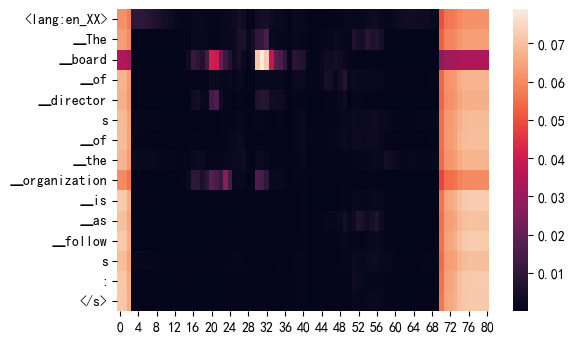

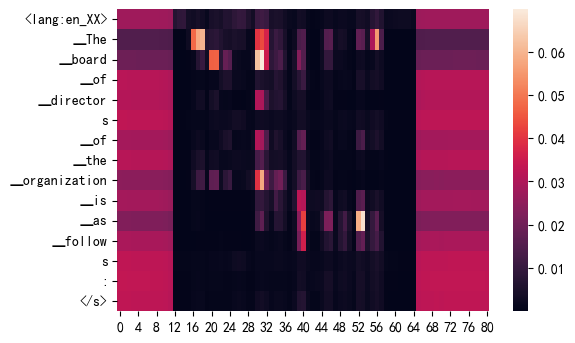

In [85]:
plt.figure(dpi=100)
sns.heatmap(good_st_out[1]['attn'][0][0].detach().cpu(), yticklabels=[dict.symbols[t] for t in target])
plt.figure(dpi=100)
sns.heatmap(bad_st_out[1]['attn'][0][0].detach().cpu(), yticklabels=[dict.symbols[t] for t in target])

In [86]:
# plt.figure(dpi=100)
# sns.heatmap(gebd_out[1]['attn'][0][0].detach().cpu(), yticklabels=[dict.symbols[t] for t in target])

In [87]:
# plt.figure(dpi=100)
# sns.heatmap(begd_out[1]['attn'][0][0].detach().cpu(), yticklabels=[dict.symbols[t] for t in target])

In [88]:
# print([dict.symbols[t] for t in target], df['src_text'][df['tgt_text'] == refs[b_idx]].tolist(), sep='\n')

In [89]:
src_tokenized = " ".join(spm.EncodeAsPieces(df['src_text'][idx]))
src_text = dict.encode_line(
    src_tokenized, add_if_not_exist=False, append_eos=True
).long()
lang_tag = MultilingualTripletDataset.LANG_TAG_TEMPLATE.format('zh_CN')
src_lang_tag_idx = dict.index(lang_tag)
src_text = th.cat(
    (th.LongTensor([src_lang_tag_idx]), src_text),
    0
)
src_text_lengths = th.tensor(
    [src_text.size(0)], dtype=th.long
)
src_text = fairseq_data_utils.collate_tokens(
    [src_text],
    dict.pad(),
    dict.eos(),
    left_pad=False,
    move_eos_to_beginning=False,
)
src_text = src_text.to(device)
src_text_lengths = src_text_lengths.to(device)
mt_input = {
    "src_tokens": src_text,
    "src_lengths": src_text_lengths,
    "prev_output_tokens": prev_output_tokens
}
good_mt_out, good_mt_enc_out = good_model.forward_with_internal(**mt_input)
bad_mt_out, bad_mt_enc_out = bad_model.forward_with_internal(**mt_input)

<AxesSubplot:>

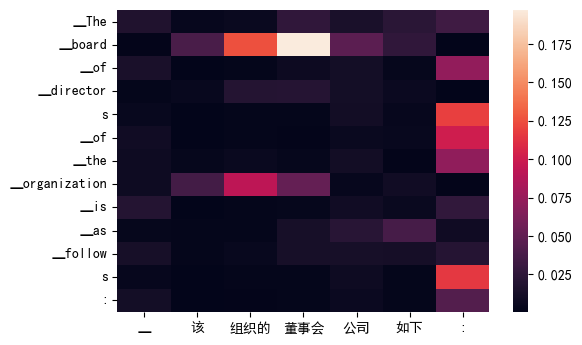

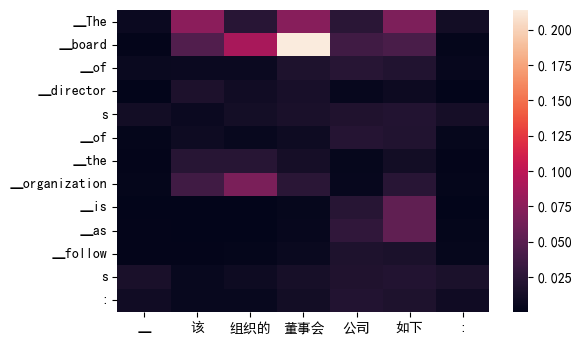

In [90]:
plt.figure(dpi=100)
sns.heatmap(good_mt_out[1]['attn'][0][0].detach().cpu()[1:-1, 1:-1], xticklabels=[dict.symbols[s] for s in src_text[0]][1:-1], yticklabels=[dict.symbols[t] for t in target][1:-1])
plt.figure(dpi=100)
sns.heatmap(bad_mt_out[1]['attn'][0][0].detach().cpu()[1:-1, 1:-1], xticklabels=[dict.symbols[s] for s in src_text[0]][1:-1], yticklabels=[dict.symbols[t] for t in target][1:-1])

<AxesSubplot:>

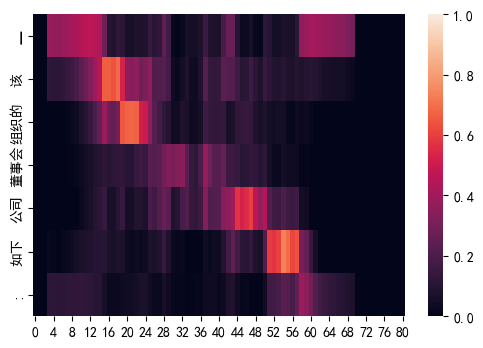

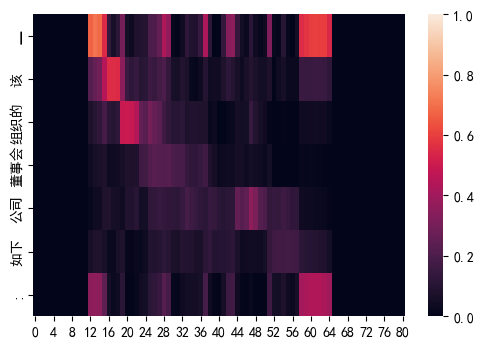

In [91]:
good_mt = good_mt_enc_out.encoder_out.squeeze()
good_st = good_st_enc_out.encoder_out.squeeze()
good_sim_matrix = F.cosine_similarity(
    good_mt.unsqueeze(1),
    good_st.unsqueeze(0),
    dim=-1
)
plt.figure(dpi=100)
sns.heatmap(good_sim_matrix.detach().cpu()[1:-1], yticklabels=[dict.symbols[s] for s in src_text[0]][1:-1], vmin=0, vmax=1)

bad_mt = bad_mt_enc_out.encoder_out.squeeze()
bad_st = bad_st_enc_out.encoder_out.squeeze()
bad_sim_matrix = F.cosine_similarity(
    bad_mt.unsqueeze(1),
    bad_st.unsqueeze(0),
    dim=-1
)
plt.figure(dpi=100)
sns.heatmap(bad_sim_matrix.detach().cpu()[1:-1], yticklabels=[dict.symbols[s] for s in src_text[0]][1:-1], vmin=0, vmax=1)

In [92]:
F.cosine_similarity(good_mt.mean(dim=0), good_st.mean(dim=0), dim=-1), F.cosine_similarity(bad_mt.mean(dim=0), bad_st.mean(dim=0), dim=-1)

(tensor(0.5193, device='cuda:4', grad_fn=<DivBackward0>),
 tensor(0.5102, device='cuda:4', grad_fn=<DivBackward0>))

<AxesSubplot:>

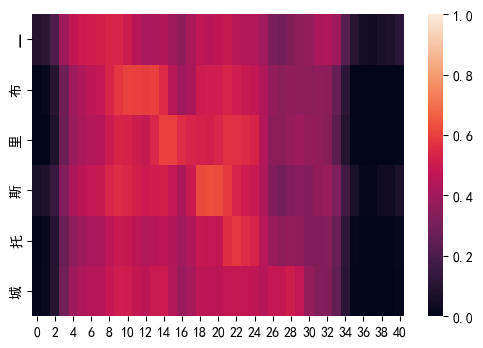

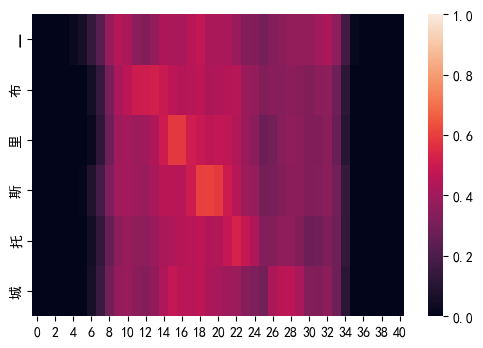

In [61]:
good_mt = good_mt_enc_out.encoder_embedding.squeeze()
good_st = good_st_enc_out.encoder_embedding.squeeze()
good_sim_matrix = F.cosine_similarity(
    good_mt.unsqueeze(1),
    good_st.unsqueeze(0),
    dim=-1
)
plt.figure(dpi=100)
sns.heatmap(good_sim_matrix.detach().cpu()[1:-1], yticklabels=[dict.symbols[s] for s in src_text[0]][1:-1], vmin=0, vmax=1)

bad_mt = bad_mt_enc_out.encoder_embedding.squeeze()
bad_st = bad_st_enc_out.encoder_embedding.squeeze()
bad_sim_matrix = F.cosine_similarity(
    bad_mt.unsqueeze(1),
    bad_st.unsqueeze(0),
    dim=-1
)
plt.figure(dpi=100)
sns.heatmap(bad_sim_matrix.detach().cpu()[1:-1], yticklabels=[dict.symbols[s] for s in src_text[0]][1:-1], vmin=0, vmax=1)

In [62]:
print([dict.symbols[s] for s in src_text[0]][1:-1])

['▁', '布', '里', '斯', '托', '城']


In [74]:
align = th.load(os.path.join(root, '16kHz', df['id'][idx] + '.pt'))

In [75]:
align[0]

[(1, 1), (2, 2), (3, 3), (5, 5), (6, 6)]

In [78]:
l = np.floor((align[1] * good_st.size(0))[:, 0])
r = np.ceil((align[1] * good_st.size(0))[:, 1])
print(*zip(l, r))

(10.0, 15.0) (14.0, 17.0) (16.0, 22.0) (23.0, 29.0) (28.0, 36.0)


<AxesSubplot:>

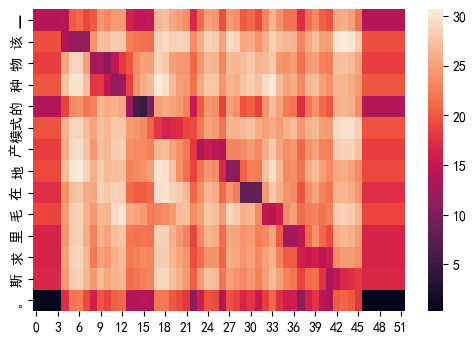

In [34]:
good_l2_matrix = (good_mt.unsqueeze(1) - good_st.unsqueeze(0)).norm(dim=-1)
plt.figure(dpi=100)
sns.heatmap(good_l2_matrix.detach().cpu()[1:-1], yticklabels=[dict.symbols[s] for s in src_text[0]][1:-1])

In [35]:
(good_st[15:20].mean(dim=0) - good_mt[2]).norm()

SyntaxError: EOL while scanning string literal (3650164504.py, line 1)

<AxesSubplot:>

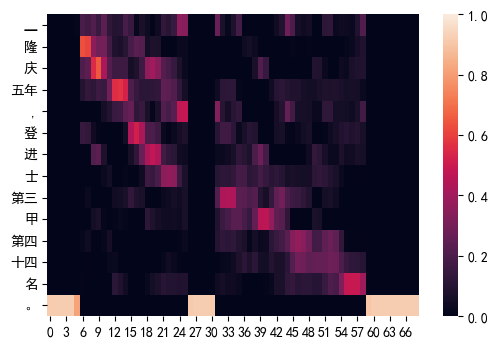

In [ ]:
bad_good_sim_matrix = F.cosine_similarity(
    good_mt.unsqueeze(1),
    bad_st.unsqueeze(0),
    dim=-1
)
plt.figure(dpi=100)
sns.heatmap(bad_good_sim_matrix.detach().cpu()[1:-1], yticklabels=[dict.symbols[s] for s in src_text[0]][1:-1], vmin=0, vmax=1)

<AxesSubplot:>

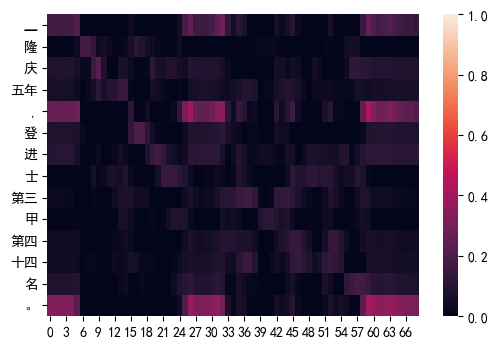

In [145]:
good_t = good_mt_enc_out.encoder_embedding.squeeze()
good_s = good_st_enc_out.encoder_embedding.squeeze()
good_surface_sim_matrix = F.cosine_similarity(
    good_t.unsqueeze(1),
    good_s.unsqueeze(0),
    dim=-1
)
plt.figure(dpi=100)
sns.heatmap(good_surface_sim_matrix.detach().cpu()[1:-1], yticklabels=[dict.symbols[s] for s in src_text[0]][1:-1], vmin=0, vmax=1)

Text(0.5, 0, 'time step')

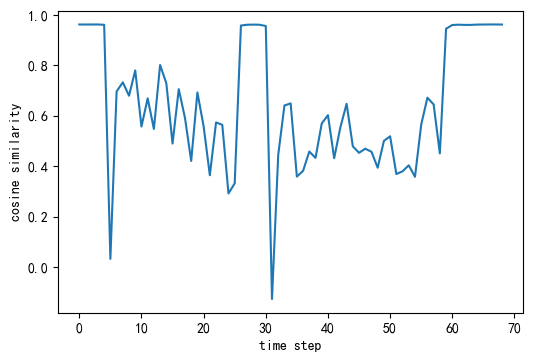

In [146]:
st_sim_matrix = F.cosine_similarity(
    good_st,
    bad_st,
    dim=-1
)
plt.figure(dpi=100)
plt.plot(st_sim_matrix.detach().cpu())
plt.ylabel('cosine similarity')
plt.xlabel('time step')

Text(0.5, 0, 'time step')

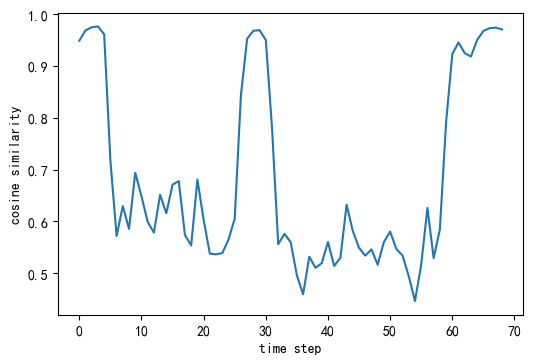

In [147]:
emb_sim_matrix = F.cosine_similarity(
    good_st_enc_out.encoder_embedding,
    bad_st_enc_out.encoder_embedding,
    dim=-1
)
plt.figure(dpi=100)
plt.plot(emb_sim_matrix.detach().cpu()[0])
plt.ylabel('cosine similarity')
plt.xlabel('time step')